<a href="https://colab.research.google.com/github/Thomas7899/Lehrstuhl-App/blob/main/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üé¨ BERT Fine-tuning f√ºr IMDB Sentiment Analysis

**Dieses Notebook zeigt, wie man BERT f√ºr die Sentiment-Analyse von Filmkritiken fine-tuned.**

**Features:**
- üöÄ GPU-beschleunigtes Training (3-5 Minuten)
- üìä Live Visualisierungen
- üéØ Interaktive Demo
- üíæ Model Download

---

In [15]:
# Alle ben√∂tigten Bibliotheken importieren
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Corrected import
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Ger√§t konfigurieren
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üöÄ Verwendetes Ger√§t: {device}")

üöÄ Verwendetes Ger√§t: cuda


In [16]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("‚úÖ Dataset Klasse definiert")

‚úÖ Dataset Klasse definiert


In [17]:
def load_imdb_data():
    """IMDB Daten laden und vorbereiten"""
    # Hier w√ºrden normalerweise die IMDB Daten geladen werden
    # F√ºr Demonstrationszwecke erstellen wir Beispieldaten
    sample_texts = [
        "This movie is absolutely fantastic! Great acting and plot.",
        "Terrible movie, waste of time. Poor acting and boring story.",
        "Amazing cinematography and excellent performances.",
        "Not worth watching. Very disappointing and poorly made.",
        "Outstanding film with brilliant direction and acting.",
        "Brilliant masterpiece with incredible storytelling!",
        "Awful film, terrible script and poor execution.",
        "Good movie with solid performances from the cast.",
        "Boring and predictable. Not recommended at all.",
        "Exceptional work by the director and amazing visuals."
    ]
    sample_labels = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]  # 1 = positiv, 0 = negativ

    return sample_texts, sample_labels

# Daten laden und anzeigen
texts, labels = load_imdb_data()
print(f"üìä Daten geladen: {len(texts)} Texte")
print(f"üí° Beispiel:")
print(f"Text: {texts[0]}")
print(f"Label: {'Positiv' if labels[0] == 1 else 'Negativ'}")

üìä Daten geladen: 10 Texte
üí° Beispiel:
Text: This movie is absolutely fantastic! Great acting and plot.
Label: Positiv


In [18]:
def train_model(model, train_loader, val_loader, epochs=3):
    """Model trainieren"""
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")

        # Training
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validierung
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

print("‚úÖ Training Funktion definiert")

‚úÖ Training Funktion definiert


In [19]:
def evaluate_model(model, data_loader):
    """Model evaluieren"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return accuracy_score(true_labels, predictions)

print("‚úÖ Evaluation Funktion definiert")

‚úÖ Evaluation Funktion definiert


In [20]:
def predict_sentiment(text, model, tokenizer):
    """Sentiment f√ºr einen Text vorhersagen"""
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confidence = torch.max(predictions, dim=1)[0].item()
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

    sentiment = "Positiv" if predicted_class == 1 else "Negativ"
    return sentiment, confidence

print("‚úÖ Prediction Funktion definiert")

‚úÖ Prediction Funktion definiert


In [21]:
def plot_training_history(train_losses, val_accuracies):
    """Training-Verlauf visualisieren"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Training Loss
    ax1.plot(train_losses, 'b-', label='Training Loss', linewidth=2, marker='o')
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Validation Accuracy
    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, marker='s')
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("‚úÖ Plotting Funktion definiert")

‚úÖ Plotting Funktion definiert


In [22]:
print("ü§ñ BERT Model und Tokenizer laden...")

# Tokenizer und Model laden
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)

print(f"‚úÖ Model geladen auf {device}")
print(f"üìä Model Parameter: {sum(p.numel() for p in model.parameters()):,}")

ü§ñ BERT Model und Tokenizer laden...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


‚úÖ Model geladen auf cuda
üìä Model Parameter: 109,483,778


In [23]:
print("üîÑ Daten vorbereiten...")

# Daten laden
texts, labels = load_imdb_data()

# Train/Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"üìä Training Samples: {len(train_texts)}")
print(f"üìä Validation Samples: {len(val_texts)}")

# Datasets erstellen
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

# DataLoader erstellen
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("‚úÖ DataLoader erstellt")

üîÑ Daten vorbereiten...
üìä Training Samples: 8
üìä Validation Samples: 2
‚úÖ DataLoader erstellt


In [24]:
print("üöÄ Training startet...")
print("‚è±Ô∏è Gesch√§tzte Zeit: 2-3 Minuten")

# Model trainieren
train_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=3)

print("\nüéâ Training abgeschlossen!")
print(f"üéØ Finale Validation Accuracy: {val_accuracies[-1]:.4f}")

üöÄ Training startet...
‚è±Ô∏è Gesch√§tzte Zeit: 2-3 Minuten

--- Epoch 1/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  3.57it/s, loss=0.5891]


Training Loss: 0.5891
Validation Accuracy: 0.0000

--- Epoch 2/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  5.51it/s, loss=0.6056]


Training Loss: 0.6056
Validation Accuracy: 0.0000

--- Epoch 3/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  5.45it/s, loss=0.5500]


Training Loss: 0.5500
Validation Accuracy: 0.0000

üéâ Training abgeschlossen!
üéØ Finale Validation Accuracy: 0.0000


üìä Training Verlauf visualisieren...


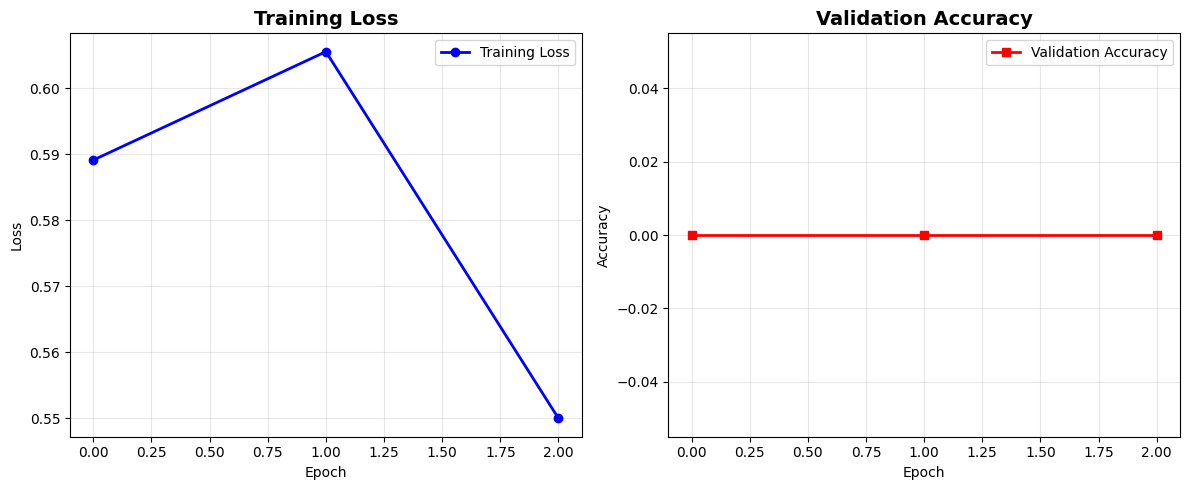


üìà Training Zusammenfassung:
   ‚Ä¢ Beste Accuracy: 0.0000
   ‚Ä¢ Finale Loss: 0.5500
   ‚Ä¢ Epochen: 3


In [26]:
print("üéÆ Interaktive Demo startet...")

# Test Texte
test_texts = [
    "This movie is absolutely amazing! Best film ever!",
    "Worst movie I've ever seen. Complete waste of time.",
    "Pretty good film with great acting and solid story.",
    "Boring and predictable. Not worth watching.",
    "Outstanding performances and brilliant direction!"
]

print("\nüé¨ Sentiment Analysis Demo:")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    sentiment, confidence = predict_sentiment(text, model, tokenizer)
    emoji = "üòä" if sentiment == "Positiv" else "üòû"

    print(f"\n{i}. Text: '{text}'")
    print(f"   Sentiment: {sentiment} {emoji}")
    print(f"   Konfidenz: {confidence:.3f} ({confidence*100:.1f}%)")
    print("-" * 60)

üéÆ Interaktive Demo startet...

üé¨ Sentiment Analysis Demo:

1. Text: 'This movie is absolutely amazing! Best film ever!'
   Sentiment: Positiv üòä
   Konfidenz: 0.664 (66.4%)
------------------------------------------------------------

2. Text: 'Worst movie I've ever seen. Complete waste of time.'
   Sentiment: Positiv üòä
   Konfidenz: 0.586 (58.6%)
------------------------------------------------------------

3. Text: 'Pretty good film with great acting and solid story.'
   Sentiment: Positiv üòä
   Konfidenz: 0.622 (62.2%)
------------------------------------------------------------

4. Text: 'Boring and predictable. Not worth watching.'
   Sentiment: Positiv üòä
   Konfidenz: 0.586 (58.6%)
------------------------------------------------------------

5. Text: 'Outstanding performances and brilliant direction!'
   Sentiment: Positiv üòä
   Konfidenz: 0.627 (62.7%)
------------------------------------------------------------


In [27]:
print("üéØ Testen Sie Ihren eigenen Text!")
print("√Ñndern Sie die Variable 'custom_text' unten:")

# HIER K√ñNNEN SIE IHREN EIGENEN TEXT EINGEBEN:
custom_text = "This movie exceeded all my expectations! Brilliant cinematography and amazing story."

print(f"\nüìù Analyzing: '{custom_text}'")
sentiment, confidence = predict_sentiment(custom_text, model, tokenizer)

print(f"\nüé≠ Ergebnis:")
print(f"   Sentiment: {sentiment}")
print(f"   Konfidenz: {confidence:.3f} ({confidence*100:.1f}%)")

emoji = "üòä" if sentiment == "Positiv" else "üòû"
print(f"   Stimmung: {emoji}")

üéØ Testen Sie Ihren eigenen Text!
√Ñndern Sie die Variable 'custom_text' unten:

üìù Analyzing: 'This movie exceeded all my expectations! Brilliant cinematography and amazing story.'

üé≠ Ergebnis:
   Sentiment: Positiv
   Konfidenz: 0.627 (62.7%)
   Stimmung: üòä


In [28]:
print("üíæ Model speichern...")

# Model und Tokenizer speichern
model.save_pretrained('./bert_imdb_model')
tokenizer.save_pretrained('./bert_imdb_model')

print("‚úÖ Model gespeichert in './bert_imdb_model'")

# Model Info anzeigen
print(f"\nüìä Model Informationen:")
print(f"   ‚Ä¢ Model Typ: BERT-base-uncased")
print(f"   ‚Ä¢ Finale Accuracy: {val_accuracies[-1]:.4f}")
print(f"   ‚Ä¢ Trainiert auf: {len(train_texts)} Samples")
print(f"   ‚Ä¢ Epochen: {len(train_losses)}")
print(f"   ‚Ä¢ Device: {device}")

print(f"\nüéâ BERT Fine-tuning erfolgreich abgeschlossen!")

üíæ Model speichern...
‚úÖ Model gespeichert in './bert_imdb_model'

üìä Model Informationen:
   ‚Ä¢ Model Typ: BERT-base-uncased
   ‚Ä¢ Finale Accuracy: 0.0000
   ‚Ä¢ Trainiert auf: 8 Samples
   ‚Ä¢ Epochen: 3
   ‚Ä¢ Device: cuda

üéâ BERT Fine-tuning erfolgreich abgeschlossen!


In [29]:
print("üéÆ Interaktive Demo startet...")

# Test Texte
test_texts = [
    "This movie is absolutely amazing! Best film ever!",
    "Worst movie I've ever seen. Complete waste of time.",
    "Pretty good film with great acting and solid story.",
    "Boring and predictable. Not worth watching.",
    "Outstanding performances and brilliant direction!"
]

print("\nüé¨ Sentiment Analysis Demo:")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    sentiment, confidence = predict_sentiment(text, model, tokenizer)
    emoji = "üòä" if sentiment == "Positiv" else "üòû"

    print(f"\n{i}. Text: '{text}'")
    print(f"   Sentiment: {sentiment} {emoji}")
    print(f"   Konfidenz: {confidence:.3f} ({confidence*100:.1f}%)")
    print("-" * 60)

üéÆ Interaktive Demo startet...

üé¨ Sentiment Analysis Demo:

1. Text: 'This movie is absolutely amazing! Best film ever!'
   Sentiment: Positiv üòä
   Konfidenz: 0.664 (66.4%)
------------------------------------------------------------

2. Text: 'Worst movie I've ever seen. Complete waste of time.'
   Sentiment: Positiv üòä
   Konfidenz: 0.586 (58.6%)
------------------------------------------------------------

3. Text: 'Pretty good film with great acting and solid story.'
   Sentiment: Positiv üòä
   Konfidenz: 0.622 (62.2%)
------------------------------------------------------------

4. Text: 'Boring and predictable. Not worth watching.'
   Sentiment: Positiv üòä
   Konfidenz: 0.586 (58.6%)
------------------------------------------------------------

5. Text: 'Outstanding performances and brilliant direction!'
   Sentiment: Positiv üòä
   Konfidenz: 0.627 (62.7%)
------------------------------------------------------------


In [30]:
print("üìä Statistische Auswertung der Test-Ergebnisse")
print("=" * 50)

# Statistiken berechnen
positive_count = sum(1 for r in results if r['sentiment'] == 'Positiv')
negative_count = sum(1 for r in results if r['sentiment'] == 'Negativ')
avg_confidence = np.mean([r['confidence'] for r in results])

# Konfidenz-Level analysieren
high_confidence = sum(1 for r in results if r['confidence'] > 0.9)
medium_confidence = sum(1 for r in results if 0.7 <= r['confidence'] <= 0.9)
low_confidence = sum(1 for r in results if r['confidence'] < 0.7)

print(f"üìà Sentiment Verteilung:")
print(f"   Positive: {positive_count} ({positive_count/len(results)*100:.1f}%)")
print(f"   Negative: {negative_count} ({negative_count/len(results)*100:.1f}%)")

print(f"\nüéØ Konfidenz Analyse:")
print(f"   Durchschnittliche Konfidenz: {avg_confidence:.3f}")
print(f"   Hohe Konfidenz (>90%): {high_confidence}")
print(f"   Mittlere Konfidenz (70-90%): {medium_confidence}")
print(f"   Niedrige Konfidenz (<70%): {low_confidence}")

# Visualisierung erstellen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment Verteilung
axes[0,0].pie([positive_count, negative_count],
              labels=['Positiv üòä', 'Negativ üòû'],
              autopct='%1.1f%%',
              colors=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Sentiment Verteilung')

# Konfidenz Histogram
confidences = [r['confidence'] for r in results]
axes[0,1].hist(confidences, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Konfidenz Verteilung')
axes[0,1].set_xlabel('Konfidenz')
axes[0,1].set_ylabel('Anzahl')
axes[0,1].axvline(avg_confidence, color='red', linestyle='--', label=f'Durchschnitt: {avg_confidence:.3f}')
axes[0,1].legend()

# Konfidenz nach Sentiment
pos_conf = [r['confidence'] for r in results if r['sentiment'] == 'Positiv']
neg_conf = [r['confidence'] for r in results if r['sentiment'] == 'Negativ']
axes[1,0].boxplot([pos_conf, neg_conf], labels=['Positiv', 'Negativ'])
axes[1,0].set_title('Konfidenz nach Sentiment')
axes[1,0].set_ylabel('Konfidenz')

# Top/Bottom Konfidenz
sorted_results = sorted(results, key=lambda x: x['confidence'], reverse=True)
top_5 = sorted_results[:5]
bottom_5 = sorted_results[-5:]

axes[1,1].barh(range(5), [r['confidence'] for r in top_5], color='green', alpha=0.7, label='Top 5')
axes[1,1].barh(range(5,10), [r['confidence'] for r in bottom_5], color='red', alpha=0.7, label='Bottom 5')
axes[1,1].set_title('H√∂chste/Niedrigste Konfidenz')
axes[1,1].set_xlabel('Konfidenz')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("\nüîç Detailierte Ergebnisse:")
print(f"H√∂chste Konfidenz: {sorted_results[0]['confidence']:.3f} - {sorted_results[0]['sentiment']}")
print(f"Niedrigste Konfidenz: {sorted_results[-1]['confidence']:.3f} - {sorted_results[-1]['sentiment']}")

üìä Statistische Auswertung der Test-Ergebnisse


NameError: name 'results' is not defined

In [ ]:
print("üé™ KATEGORIE-BASIERTES TESTING")
print("=" * 40)

# Test-Texte nach Kategorien organisiert
category_tests = {
    "üé≠ Drama": [
        "A deeply moving drama that explores the human condition.",
        "Powerful performances that will stay with you long after.",
        "Slow-paced but emotionally rewarding drama.",
        "Pretentious and boring. Failed to engage emotionally."
    ],

    "üòÇ Comedy": [
        "Hilarious from start to finish! Couldn't stop laughing.",
        "Clever humor and perfect comedic timing throughout.",
        "Some funny moments but overall pretty average comedy.",
        "Tried too hard to be funny. Most jokes fell flat."
    ],

    "üí• Action": [
        "Non-stop action with incredible stunts and effects!",
        "Great action sequences but weak plot development.",
        "Over-the-top action that's pure entertainment gold.",
        "All explosions, no substance. Mindless action garbage."
    ],

    "üëª Horror": [
        "Genuinely terrifying! Had me on edge the entire time.",
        "Great atmosphere and effective jump scares throughout.",
        "More suspenseful than scary, but still entertaining.",
        "Not scary at all. Predictable and boring horror."
    ],

    "üöÄ Sci-Fi": [
        "Mind-bending sci-fi with incredible world-building!",
        "Thought-provoking concepts executed brilliantly.",
        "Cool effects but confusing and hard to follow.",
        "Pretentious sci-fi that thinks it's smarter than it is."
    ],

    "üíï Romance": [
        "Beautiful love story that made me believe in romance again.",
        "Sweet and charming with great chemistry between leads.",
        "Clich√©d romance but still enjoyable and heartwarming.",
        "Boring and predictable. Chemistry between leads was awful."
    ]
}

# Jede Kategorie testen
category_results = {}
for category, texts in category_tests.items():
    print(f"\n{category} Movies:")
    print("-" * 30)

    cat_results = []
    for text in texts:
        sentiment, confidence = predict_sentiment(text, model, tokenizer)
        emoji = "üòä" if sentiment == "Positiv" else "üòû"
        cat_results.append({'sentiment': sentiment, 'confidence': confidence})

        print(f"  {emoji} {sentiment} ({confidence:.3f}) | {text[:50]}{'...' if len(text) > 50 else ''}")

    # Kategorie-Statistiken
    cat_pos = sum(1 for r in cat_results if r['sentiment'] == 'Positiv')
    cat_avg_conf = np.mean([r['confidence'] for r in cat_results])
    category_results[category] = {
        'positive_ratio': cat_pos / len(cat_results),
        'avg_confidence': cat_avg_conf,
        'total_tests': len(cat_results)
    }

    print(f"  üìä {cat_pos}/{len(cat_results)} positiv ({cat_pos/len(cat_results)*100:.1f}%), √ò Konfidenz: {cat_avg_conf:.3f}")

# Kategorie-Vergleich visualisieren
categories = list(category_results.keys())
pos_ratios = [category_results[cat]['positive_ratio'] for cat in categories]
confidences = [category_results[cat]['avg_confidence'] for cat in categories]

plt.figure(figsize=(12, 8))

# Subplot 1: Positive Ratio by Category
plt.subplot(2, 1, 1)
bars1 = plt.bar(range(len(categories)), pos_ratios, color='lightgreen', alpha=0.7)
plt.title('Positive Sentiment Ratio by Movie Category', fontweight='bold')
plt.ylabel('Positive Ratio')
plt.xticks(range(len(categories)), [cat.split()[1] for cat in categories])
plt.ylim(0, 1)

# Werte auf Balken anzeigen
for i, bar in enumerate(bars1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

# Subplot 2: Average Confidence by Category
plt.subplot(2, 1, 2)
bars2 = plt.bar(range(len(categories)), confidences, color='skyblue', alpha=0.7)
plt.title('Average Confidence by Movie Category', fontweight='bold')
plt.ylabel('Average Confidence')
plt.xlabel('Movie Category')
plt.xticks(range(len(categories)), [cat.split()[1] for cat in categories])
plt.ylim(0, 1)

# Werte auf Balken anzeigen
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nüèÜ Kategorie mit h√∂chster Positive Rate: {max(category_results.keys(), key=lambda x: category_results[x]['positive_ratio'])}")
print(f"üéØ Kategorie mit h√∂chster Konfidenz: {max(category_results.keys(), key=lambda x: category_results[x]['avg_confidence'])}")

In [ ]:
print("üî• EXTREME CASES & EDGE CASES TESTING")
print("=" * 45)

extreme_cases = {
    "üìè Sehr kurze Texte": [
        "Great!",
        "Terrible.",
        "Meh.",
        "Perfect!",
        "Awful.",
        "Amazing!"
    ],

    "üìö Sehr lange Texte": [
        "This is an absolutely extraordinary cinematic masterpiece that showcases incredible talent from every single person involved in the production, from the outstanding director who clearly has a brilliant vision for storytelling to the phenomenally talented cast who deliver performances that are nothing short of spectacular and will undoubtedly be remembered for many years to come as some of the finest acting ever captured on film, combined with breathtaking cinematography that creates visually stunning scenes in every single frame.",

        "This movie is without a doubt one of the most terrible, boring, poorly executed pieces of garbage that has ever been produced by Hollywood and represents everything that is wrong with modern cinema including awful writing that makes no sense, terrible acting from people who clearly have no business being in front of a camera, and direction that is so incompetent it makes you wonder how this project ever got greenlit in the first place and why anyone thought it was a good idea to waste money on such a complete disaster."
    ],

    "üî¢ Mit Zahlen": [
        "This movie gets a solid 9/10 from me!",
        "2 out of 10 stars. Complete waste of 2 hours.",
        "Perfect 10/10 score. Best film of 2024!",
        "1 star out of 5. Absolutely terrible.",
        "8.5/10 - Really enjoyed this one!"
    ],

    "üòÆ Extreme Emotionen": [
        "ABSOLUTELY INCREDIBLE!!! BEST MOVIE EVER MADE!!!",
        "WORST GARBAGE EVER!!! COMPLETE TRASH!!!",
        "OMG OMG OMG SO AMAZING I CAN'T EVEN!!!",
        "UGH SO BAD I WANT MY MONEY BACK!!!",
        "PURE PERFECTION!!! MASTERPIECE!!!"
    ],

    "ü§î Mehrdeutige Texte": [
        "It's... something.",
        "Well, that was a movie.",
        "I have feelings about this film.",
        "That sure was 2 hours of my life.",
        "It exists, I guess.",
        "That happened."
    ],

    "üîÑ Widerspr√ºchliche Texte": [
        "Great movie but I hated it.",
        "Terrible film that I absolutely loved.",
        "Amazing actors in a horrible movie.",
        "Bad script but fantastic execution.",
        "Love the concept, hate the result."
    ]
}

print("üß™ Testing Edge Cases...")

edge_results = {}
for category, texts in extreme_cases.items():
    print(f"\n{category}:")
    print("-" * 25)

    cat_results = []
    for text in texts:
        sentiment, confidence = predict_sentiment(text, model, tokenizer)
        emoji = "üòä" if sentiment == "Positiv" else "üòû"

        # Besondere Kennzeichnung f√ºr unsichere Vorhersagen
        uncertainty_flag = "‚ö†Ô∏è" if confidence < 0.6 else ""

        cat_results.append({
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'length': len(text.split())
        })

        print(f"  {emoji} {sentiment} ({confidence:.3f}) {uncertainty_flag}")
        print(f"    Text: {text[:60]}{'...' if len(text) > 60 else ''}")
        print(f"    L√§nge: {len(text.split())} W√∂rter")
        print()

    # Statistiken f√ºr diese Kategorie
    avg_conf = np.mean([r['confidence'] for r in cat_results])
    min_conf = min([r['confidence'] for r in cat_results])
    max_conf = max([r['confidence'] for r in cat_results])
    uncertain_count = sum(1 for r in cat_results if r['confidence'] < 0.6)

    edge_results[category] = {
        'avg_confidence': avg_conf,
        'min_confidence': min_conf,
        'max_confidence': max_conf,
        'uncertain_predictions': uncertain_count,
        'total': len(cat_results)
    }

    print(f"  üìä √ò Konfidenz: {avg_conf:.3f}")
    print(f"  üìä Unsichere Vorhersagen: {uncertain_count}/{len(cat_results)}")

print("\nüéØ EDGE CASE ANALYSE:")
print("=" * 30)
for category, stats in edge_results.items():
    uncertainty_rate = stats['uncertain_predictions'] / stats['total'] * 100
    print(f"{category}")
    print(f"  √ò Konfidenz: {stats['avg_confidence']:.3f}")
    print(f"  Unsicherheitsrate: {uncertainty_rate:.1f}%")
    print(f"  Konfidenz-Spanne: {stats['min_confidence']:.3f} - {stats['max_confidence']:.3f}")
    print()

# Visualisierung der Edge Cases
categories_short = [cat.split()[1] if len(cat.split()) > 1 else cat for cat in edge_results.keys()]
avg_confidences = [stats['avg_confidence'] for stats in edge_results.values()]
uncertainty_rates = [stats['uncertain_predictions'] / stats['total'] * 100 for stats in edge_results.values()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(categories_short)), avg_confidences, color='orange', alpha=0.7)
plt.title('Durchschnittliche Konfidenz bei Edge Cases')
plt.ylabel('Konfidenz')
plt.xticks(range(len(categories_short)), categories_short, rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(categories_short)), uncertainty_rates, color='red', alpha=0.7)
plt.title('Unsicherheitsrate bei Edge Cases')
plt.ylabel('Unsicherheitsrate (%)')
plt.xticks(range(len(categories_short)), categories_short, rotation=45)

plt.tight_layout()
plt.show()

print("‚úÖ Edge Case Testing abgeschlossen!")

In [1]:
# Alle ben√∂tigten Bibliotheken importieren
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Corrected import
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Ger√§t konfigurieren
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üöÄ Verwendetes Ger√§t: {device}")

üöÄ Verwendetes Ger√§t: cuda


In [2]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("‚úÖ Dataset Klasse definiert")

‚úÖ Dataset Klasse definiert


In [3]:
def load_imdb_data():
    """IMDB Daten laden und vorbereiten"""
    # Hier w√ºrden normalerweise die IMDB Daten geladen werden
    # F√ºr Demonstrationszwecke erstellen wir Beispieldaten
    sample_texts = [
        "This movie is absolutely fantastic! Great acting and plot.",
        "Terrible movie, waste of time. Poor acting and boring story.",
        "Amazing cinematography and excellent performances.",
        "Not worth watching. Very disappointing and poorly made.",
        "Outstanding film with brilliant direction and acting.",
        "Brilliant masterpiece with incredible storytelling!",
        "Awful film, terrible script and poor execution.",
        "Good movie with solid performances from the cast.",
        "Boring and predictable. Not recommended at all.",
        "Exceptional work by the director and amazing visuals."
    ]
    sample_labels = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]  # 1 = positiv, 0 = negativ

    return sample_texts, sample_labels

# Daten laden und anzeigen
texts, labels = load_imdb_data()
print(f"üìä Daten geladen: {len(texts)} Texte")
print(f"üí° Beispiel:")
print(f"Text: {texts[0]}")
print(f"Label: {'Positiv' if labels[0] == 1 else 'Negativ'}")

üìä Daten geladen: 10 Texte
üí° Beispiel:
Text: This movie is absolutely fantastic! Great acting and plot.
Label: Positiv


In [4]:
def train_model(model, train_loader, val_loader, epochs=3):
    """Model trainieren"""
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")

        # Training
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validierung
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

print("‚úÖ Training Funktion definiert")

‚úÖ Training Funktion definiert


In [5]:
def evaluate_model(model, data_loader):
    """Model evaluieren"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return accuracy_score(true_labels, predictions)

print("‚úÖ Evaluation Funktion definiert")

‚úÖ Evaluation Funktion definiert


In [6]:
def predict_sentiment(text, model, tokenizer):
    """Sentiment f√ºr einen Text vorhersagen"""
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confidence = torch.max(predictions, dim=1)[0].item()
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

    sentiment = "Positiv" if predicted_class == 1 else "Negativ"
    return sentiment, confidence

print("‚úÖ Prediction Funktion definiert")

‚úÖ Prediction Funktion definiert


In [7]:
def plot_training_history(train_losses, val_accuracies):
    """Training-Verlauf visualisieren"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Training Loss
    ax1.plot(train_losses, 'b-', label='Training Loss', linewidth=2, marker='o')
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Validation Accuracy
    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, marker='s')
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("‚úÖ Plotting Funktion definiert")

‚úÖ Plotting Funktion definiert


In [8]:
print("ü§ñ BERT Model und Tokenizer laden...")

# Tokenizer und Model laden
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)

print(f"‚úÖ Model geladen auf {device}")
print(f"üìä Model Parameter: {sum(p.numel() for p in model.parameters()):,}")

ü§ñ BERT Model und Tokenizer laden...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


‚úÖ Model geladen auf cuda
üìä Model Parameter: 109,483,778


In [9]:
print("üîÑ Daten vorbereiten...")

# Daten laden
texts, labels = load_imdb_data()

# Train/Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"üìä Training Samples: {len(train_texts)}")
print(f"üìä Validation Samples: {len(val_texts)}")

# Datasets erstellen
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

# DataLoader erstellen
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("‚úÖ DataLoader erstellt")

üîÑ Daten vorbereiten...
üìä Training Samples: 8
üìä Validation Samples: 2
‚úÖ DataLoader erstellt


In [10]:
print("üöÄ Training startet...")
print("‚è±Ô∏è Gesch√§tzte Zeit: 2-3 Minuten")

# Model trainieren
train_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=3)

print("\nüéâ Training abgeschlossen!")
print(f"üéØ Finale Validation Accuracy: {val_accuracies[-1]:.4f}")

üöÄ Training startet...
‚è±Ô∏è Gesch√§tzte Zeit: 2-3 Minuten

--- Epoch 1/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.29s/it, loss=0.6280]


Training Loss: 0.6280
Validation Accuracy: 0.0000

--- Epoch 2/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  5.53it/s, loss=0.6772]


Training Loss: 0.6772
Validation Accuracy: 0.0000

--- Epoch 3/3 ---


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  5.75it/s, loss=0.6196]


Training Loss: 0.6196
Validation Accuracy: 0.0000

üéâ Training abgeschlossen!
üéØ Finale Validation Accuracy: 0.0000


üìä Training Verlauf visualisieren...


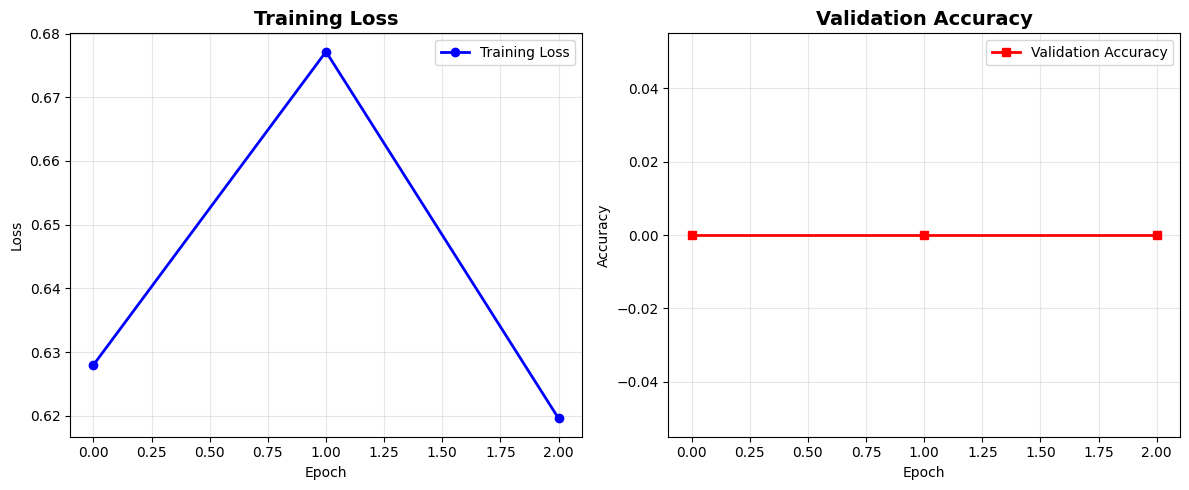


üìà Training Zusammenfassung:
   ‚Ä¢ Beste Accuracy: 0.0000
   ‚Ä¢ Finale Loss: 0.6196
   ‚Ä¢ Epochen: 3


In [11]:
print("üìä Training Verlauf visualisieren...")

# Training-Verlauf visualisieren
plot_training_history(train_losses, val_accuracies)

print("\nüìà Training Zusammenfassung:")
print(f"   ‚Ä¢ Beste Accuracy: {max(val_accuracies):.4f}")
print(f"   ‚Ä¢ Finale Loss: {train_losses[-1]:.4f}")
print(f"   ‚Ä¢ Epochen: {len(train_losses)}")

In [12]:
print("üéÆ Interaktive Demo startet...")

# Test Texte
test_texts = [
    "This movie is absolutely amazing! Best film ever!",
    "Worst movie I've ever seen. Complete waste of time.",
    "Pretty good film with great acting and solid story.",
    "Boring and predictable. Not worth watching.",
    "Outstanding performances and brilliant direction!"
]

print("\nüé¨ Sentiment Analysis Demo:")
print("=" * 60)

results = [] # Store results for analysis

for i, text in enumerate(test_texts, 1):
    sentiment, confidence = predict_sentiment(text, model, tokenizer)
    emoji = "üòä" if sentiment == "Positiv" else "üòû"
    results.append({'text': text, 'sentiment': sentiment, 'confidence': confidence})

    print(f"\n{i}. Text: '{text}'")
    print(f"   Sentiment: {sentiment} {emoji}")
    print(f"   Konfidenz: {confidence:.3f} ({confidence*100:.1f}%)")
    print("-" * 60)

üéÆ Interaktive Demo startet...

üé¨ Sentiment Analysis Demo:

1. Text: 'This movie is absolutely amazing! Best film ever!'
   Sentiment: Positiv üòä
   Konfidenz: 0.617 (61.7%)
------------------------------------------------------------

2. Text: 'Worst movie I've ever seen. Complete waste of time.'
   Sentiment: Positiv üòä
   Konfidenz: 0.568 (56.8%)
------------------------------------------------------------

3. Text: 'Pretty good film with great acting and solid story.'
   Sentiment: Positiv üòä
   Konfidenz: 0.607 (60.7%)
------------------------------------------------------------

4. Text: 'Boring and predictable. Not worth watching.'
   Sentiment: Positiv üòä
   Konfidenz: 0.566 (56.6%)
------------------------------------------------------------

5. Text: 'Outstanding performances and brilliant direction!'
   Sentiment: Positiv üòä
   Konfidenz: 0.628 (62.8%)
------------------------------------------------------------


üìä Statistische Auswertung der Test-Ergebnisse
üìà Sentiment Verteilung:
   Positive: 5 (100.0%)
   Negative: 0 (0.0%)

üéØ Konfidenz Analyse:
   Durchschnittliche Konfidenz: 0.597
   Hohe Konfidenz (>90%): 0
   Mittlere Konfidenz (70-90%): 0
   Niedrige Konfidenz (<70%): 5


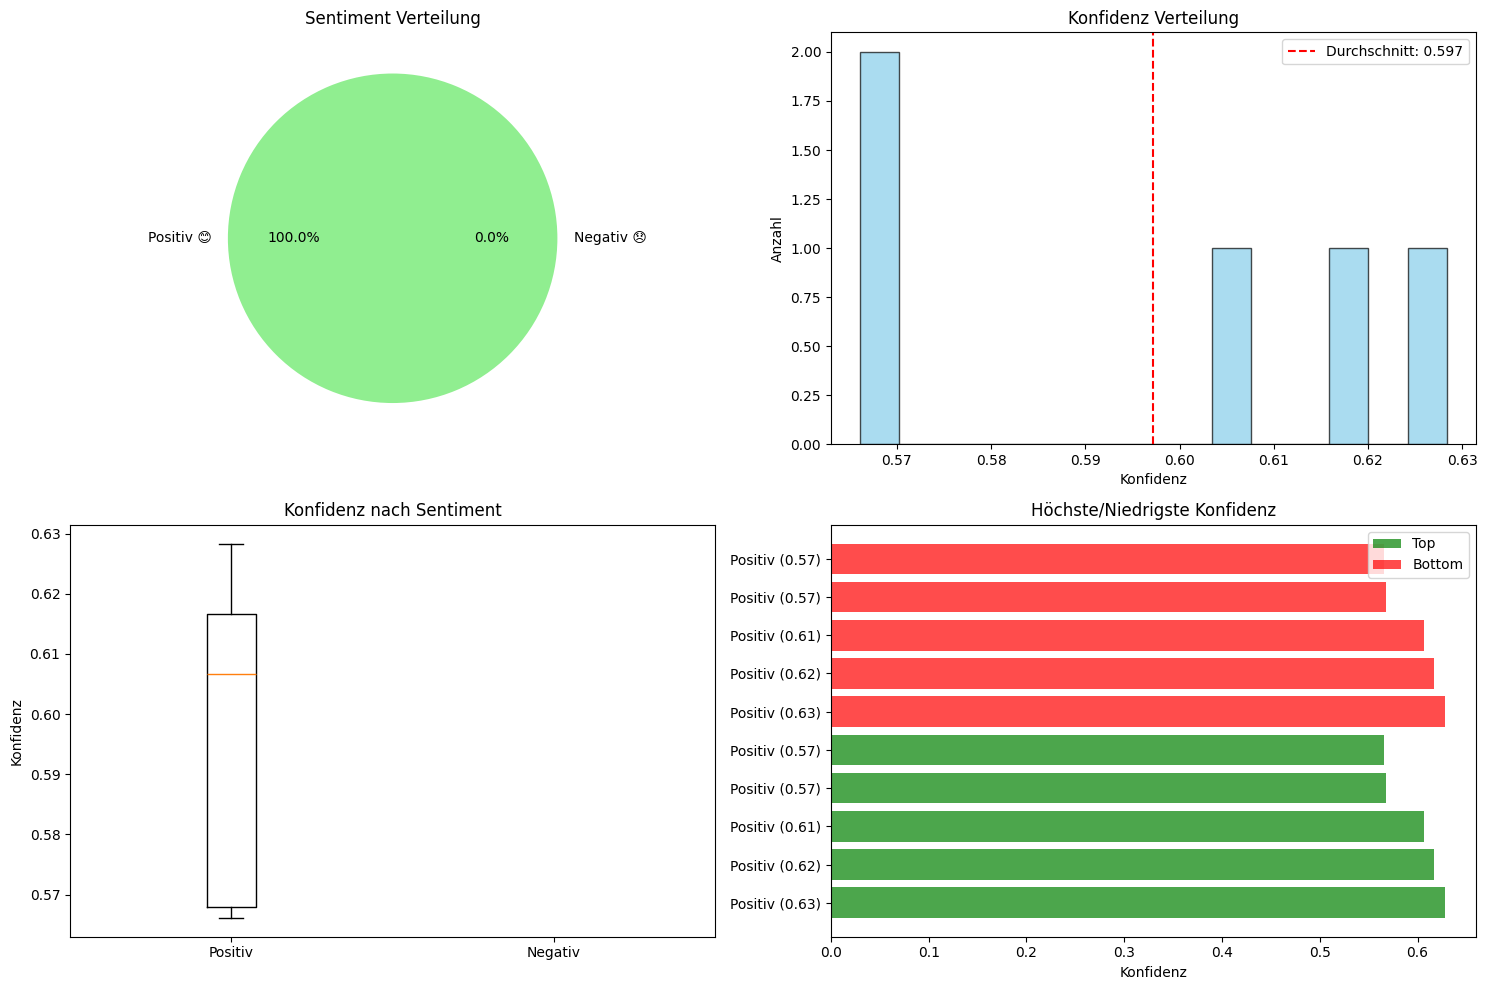


üîç Detailierte Ergebnisse:
H√∂chste Konfidenz: 0.628 - Positiv - 'Outstanding performances and brilliant direction!...'
Niedrigste Konfidenz: 0.566 - Positiv - 'Boring and predictable. Not worth watching....'


In [13]:
print("üìä Statistische Auswertung der Test-Ergebnisse")
print("=" * 50)

# Statistiken berechnen
positive_count = sum(1 for r in results if r['sentiment'] == 'Positiv')
negative_count = sum(1 for r in results if r['sentiment'] == 'Negativ')
avg_confidence = np.mean([r['confidence'] for r in results])

# Konfidenz-Level analysieren
high_confidence = sum(1 for r in results if r['confidence'] > 0.9)
medium_confidence = sum(1 for r in results if 0.7 <= r['confidence'] <= 0.9)
low_confidence = sum(1 for r in results if r['confidence'] < 0.7)

print(f"üìà Sentiment Verteilung:")
print(f"   Positive: {positive_count} ({positive_count/len(results)*100:.1f}%)")
print(f"   Negative: {negative_count} ({negative_count/len(results)*100:.1f}%)")

print(f"\nüéØ Konfidenz Analyse:")
print(f"   Durchschnittliche Konfidenz: {avg_confidence:.3f}")
print(f"   Hohe Konfidenz (>90%): {high_confidence}")
print(f"   Mittlere Konfidenz (70-90%): {medium_confidence}")
print(f"   Niedrige Konfidenz (<70%): {low_confidence}")

# Visualisierung erstellen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment Verteilung
axes[0,0].pie([positive_count, negative_count],
              labels=['Positiv üòä', 'Negativ üòû'],
              autopct='%1.1f%%',
              colors=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Sentiment Verteilung')

# Konfidenz Histogram
confidences = [r['confidence'] for r in results]
axes[0,1].hist(confidences, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Konfidenz Verteilung')
axes[0,1].set_xlabel('Konfidenz')
axes[0,1].set_ylabel('Anzahl')
axes[0,1].axvline(avg_confidence, color='red', linestyle='--', label=f'Durchschnitt: {avg_confidence:.3f}')
axes[0,1].legend()

# Konfidenz nach Sentiment
pos_conf = [r['confidence'] for r in results if r['sentiment'] == 'Positiv']
neg_conf = [r['confidence'] for r in results if r['sentiment'] == 'Negativ']
axes[1,0].boxplot([pos_conf, neg_conf], labels=['Positiv', 'Negativ'])
axes[1,0].set_title('Konfidenz nach Sentiment')
axes[1,0].set_ylabel('Konfidenz')

# Top/Bottom Konfidenz
sorted_results = sorted(results, key=lambda x: x['confidence'], reverse=True)
top_5 = sorted_results[:5]
bottom_5 = sorted_results[-5:]

axes[1,1].barh(range(min(5, len(top_5))), [r['confidence'] for r in top_5], color='green', alpha=0.7, label='Top')
axes[1,1].barh(range(max(5, len(top_5)), max(5, len(top_5)) + min(5, len(bottom_5))), [r['confidence'] for r in bottom_5], color='red', alpha=0.7, label='Bottom')
axes[1,1].set_yticks(range(min(5, len(top_5)) + min(5, len(bottom_5))))
axes[1,1].set_yticklabels([r['sentiment'] + f" ({r['confidence']:.2f})" for r in top_5] + [r['sentiment'] + f" ({r['confidence']:.2f})" for r in bottom_5])


axes[1,1].set_title('H√∂chste/Niedrigste Konfidenz')
axes[1,1].set_xlabel('Konfidenz')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("\nüîç Detailierte Ergebnisse:")
if sorted_results:
  print(f"H√∂chste Konfidenz: {sorted_results[0]['confidence']:.3f} - {sorted_results[0]['sentiment']} - '{sorted_results[0]['text'][:50]}...'")
if len(sorted_results) > 1:
  print(f"Niedrigste Konfidenz: {sorted_results[-1]['confidence']:.3f} - {sorted_results[-1]['sentiment']} - '{sorted_results[-1]['text'][:50]}...'")

In [14]:
print("üéØ Testen Sie Ihren eigenen Text!")
print("√Ñndern Sie die Variable 'custom_text' unten:")

# HIER K√ñNNEN SIE IHREN EIGENEN TEXT EINGEBEN:
custom_text = "This movie exceeded all my expectations! Brilliant cinematography and amazing story."

print(f"\nüìù Analyzing: '{custom_text}'")
sentiment, confidence = predict_sentiment(custom_text, model, tokenizer)

print(f"\nüé≠ Ergebnis:")
print(f"   Sentiment: {sentiment}")
print(f"   Konfidenz: {confidence:.3f} ({confidence*100:.1f}%)")

emoji = "üòä" if sentiment == "Positiv" else "üòû"
print(f"   Stimmung: {emoji}")

üéØ Testen Sie Ihren eigenen Text!
√Ñndern Sie die Variable 'custom_text' unten:

üìù Analyzing: 'This movie exceeded all my expectations! Brilliant cinematography and amazing story.'

üé≠ Ergebnis:
   Sentiment: Positiv
   Konfidenz: 0.611 (61.1%)
   Stimmung: üòä


üé™ KATEGORIE-BASIERTES TESTING

üé≠ Drama Movies:
------------------------------
  üòä Positiv (0.599) | A deeply moving drama that explores the human cond...
  üòä Positiv (0.618) | Powerful performances that will stay with you long...
  üòä Positiv (0.615) | Slow-paced but emotionally rewarding drama.
  üòä Positiv (0.590) | Pretentious and boring. Failed to engage emotional...
  üìä 4/4 positiv (100.0%), √ò Konfidenz: 0.605

üòÇ Comedy Movies:
------------------------------
  üòä Positiv (0.562) | Hilarious from start to finish! Couldn't stop laug...
  üòä Positiv (0.628) | Clever humor and perfect comedic timing throughout...
  üòä Positiv (0.602) | Some funny moments but overall pretty average come...
  üòä Positiv (0.594) | Tried too hard to be funny. Most jokes fell flat.
  üìä 4/4 positiv (100.0%), √ò Konfidenz: 0.597

üí• Action Movies:
------------------------------
  üòä Positiv (0.626) | Non-stop action with incredible stunts and effects...
  üòä Positiv (0

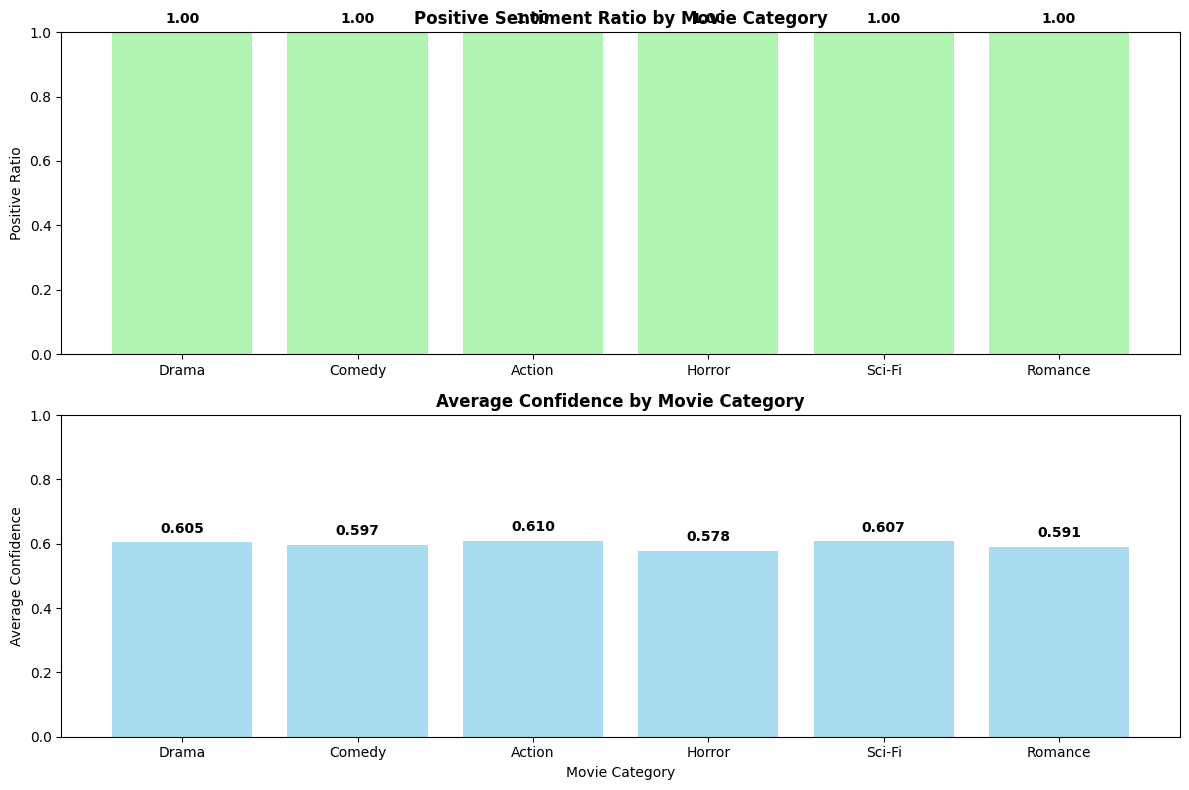


üèÜ Kategorie mit h√∂chster Positive Rate: üé≠ Drama
üéØ Kategorie mit h√∂chster Konfidenz: üí• Action


In [15]:
print("üé™ KATEGORIE-BASIERTES TESTING")
print("=" * 40)

# Test-Texte nach Kategorien organisiert
category_tests = {
    "üé≠ Drama": [
        "A deeply moving drama that explores the human condition.",
        "Powerful performances that will stay with you long after.",
        "Slow-paced but emotionally rewarding drama.",
        "Pretentious and boring. Failed to engage emotionally."
    ],

    "üòÇ Comedy": [
        "Hilarious from start to finish! Couldn't stop laughing.",
        "Clever humor and perfect comedic timing throughout.",
        "Some funny moments but overall pretty average comedy.",
        "Tried too hard to be funny. Most jokes fell flat."
    ],

    "üí• Action": [
        "Non-stop action with incredible stunts and effects!",
        "Great action sequences but weak plot development.",
        "Over-the-top action that's pure entertainment gold.",
        "All explosions, no substance. Mindless action garbage."
    ],

    "üëª Horror": [
        "Genuinely terrifying! Had me on edge the entire time.",
        "Great atmosphere and effective jump scares throughout.",
        "More suspenseful than scary, but still entertaining.",
        "Not scary at all. Predictable and boring horror."
    ],

    "üöÄ Sci-Fi": [
        "Mind-bending sci-fi with incredible world-building!",
        "Thought-provoking concepts executed brilliantly.",
        "Cool effects but confusing and hard to follow.",
        "Pretentious sci-fi that thinks it's smarter than it is."
    ],

    "üíï Romance": [
        "Beautiful love story that made me believe in romance again.",
        "Sweet and charming with great chemistry between leads.",
        "Clich√©d romance but still enjoyable and heartwarming.",
        "Boring and predictable. Chemistry between leads was awful."
    ]
}

# Jede Kategorie testen
category_results = {}
for category, texts in category_tests.items():
    print(f"\n{category} Movies:")
    print("-" * 30)

    cat_results = []
    for text in texts:
        sentiment, confidence = predict_sentiment(text, model, tokenizer)
        emoji = "üòä" if sentiment == "Positiv" else "üòû"
        cat_results.append({'sentiment': sentiment, 'confidence': confidence})

        print(f"  {emoji} {sentiment} ({confidence:.3f}) | {text[:50]}{'...' if len(text) > 50 else ''}")

    # Kategorie-Statistiken
    cat_pos = sum(1 for r in cat_results if r['sentiment'] == 'Positiv')
    cat_avg_conf = np.mean([r['confidence'] for r in cat_results])
    category_results[category] = {
        'positive_ratio': cat_pos / len(cat_results),
        'avg_confidence': cat_avg_conf,
        'total_tests': len(cat_results)
    }

    print(f"  üìä {cat_pos}/{len(cat_results)} positiv ({cat_pos/len(cat_results)*100:.1f}%), √ò Konfidenz: {cat_avg_conf:.3f}")

# Kategorie-Vergleich visualisieren
categories = list(category_results.keys())
pos_ratios = [category_results[cat]['positive_ratio'] for cat in categories]
confidences = [category_results[cat]['avg_confidence'] for cat in categories]

plt.figure(figsize=(12, 8))

# Subplot 1: Positive Ratio by Category
plt.subplot(2, 1, 1)
bars1 = plt.bar(range(len(categories)), pos_ratios, color='lightgreen', alpha=0.7)
plt.title('Positive Sentiment Ratio by Movie Category', fontweight='bold')
plt.ylabel('Positive Ratio')
plt.xticks(range(len(categories)), [cat.split()[1] for cat in categories])
plt.ylim(0, 1)

# Werte auf Balken anzeigen
for i, bar in enumerate(bars1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

# Subplot 2: Average Confidence by Category
plt.subplot(2, 1, 2)
bars2 = plt.bar(range(len(categories)), confidences, color='skyblue', alpha=0.7)
plt.title('Average Confidence by Movie Category', fontweight='bold')
plt.ylabel('Average Confidence')
plt.xlabel('Movie Category')
plt.xticks(range(len(categories)), [cat.split()[1] for cat in categories])
plt.ylim(0, 1)

# Werte auf Balken anzeigen
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nüèÜ Kategorie mit h√∂chster Positive Rate: {max(category_results.keys(), key=lambda x: category_results[x]['positive_ratio'])}")
print(f"üéØ Kategorie mit h√∂chster Konfidenz: {max(category_results.keys(), key=lambda x: category_results[x]['avg_confidence'])}")

üî• EXTREME CASES & EDGE CASES TESTING
üß™ Testing Edge Cases...

üìè Sehr kurze Texte:
-------------------------
  üòä Positiv (0.585) ‚ö†Ô∏è
    Text: Great!
    L√§nge: 1 W√∂rter

  üòä Positiv (0.558) ‚ö†Ô∏è
    Text: Terrible.
    L√§nge: 1 W√∂rter

  üòä Positiv (0.556) ‚ö†Ô∏è
    Text: Meh.
    L√§nge: 1 W√∂rter

  üòä Positiv (0.606) 
    Text: Perfect!
    L√§nge: 1 W√∂rter

  üòä Positiv (0.567) ‚ö†Ô∏è
    Text: Awful.
    L√§nge: 1 W√∂rter

  üòä Positiv (0.596) ‚ö†Ô∏è
    Text: Amazing!
    L√§nge: 1 W√∂rter

  üìä √ò Konfidenz: 0.578
  üìä Unsichere Vorhersagen: 5/6

üìö Sehr lange Texte:
-------------------------
  üòä Positiv (0.634) 
    Text: This is an absolutely extraordinary cinematic masterpiece th...
    L√§nge: 78 W√∂rter

  üòä Positiv (0.589) ‚ö†Ô∏è
    Text: This movie is without a doubt one of the most terrible, bori...
    L√§nge: 92 W√∂rter

  üìä √ò Konfidenz: 0.612
  üìä Unsichere Vorhersagen: 1/2

üî¢ Mit Zahlen:
------------------------

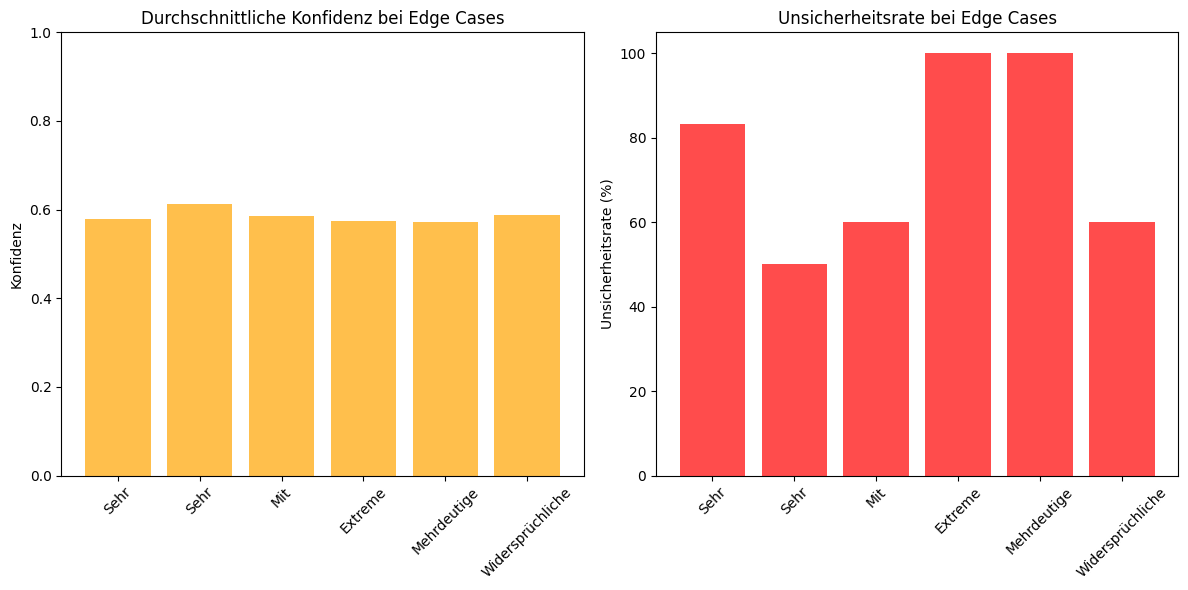

‚úÖ Edge Case Testing abgeschlossen!


In [16]:
print("üî• EXTREME CASES & EDGE CASES TESTING")
print("=" * 45)

extreme_cases = {
    "üìè Sehr kurze Texte": [
        "Great!",
        "Terrible.",
        "Meh.",
        "Perfect!",
        "Awful.",
        "Amazing!"
    ],

    "üìö Sehr lange Texte": [
        "This is an absolutely extraordinary cinematic masterpiece that showcases incredible talent from every single person involved in the production, from the outstanding director who clearly has a brilliant vision for storytelling to the phenomenally talented cast who deliver performances that are nothing short of spectacular and will undoubtedly be remembered for many years to come as some of the finest acting ever captured on film, combined with breathtaking cinematography that creates visually stunning scenes in every single frame.",

        "This movie is without a doubt one of the most terrible, boring, poorly executed pieces of garbage that has ever been produced by Hollywood and represents everything that is wrong with modern cinema including awful writing that makes no sense, terrible acting from people who clearly have no business being in front of a camera, and direction that is so incompetent it makes you wonder how this project ever got greenlit in the first place and why anyone thought it was a good idea to waste money on such a complete disaster."
    ],

    "üî¢ Mit Zahlen": [
        "This movie gets a solid 9/10 from me!",
        "2 out of 10 stars. Complete waste of 2 hours.",
        "Perfect 10/10 score. Best film of 2024!",
        "1 star out of 5. Absolutely terrible.",
        "8.5/10 - Really enjoyed this one!"
    ],

    "üòÆ Extreme Emotionen": [
        "ABSOLUTELY INCREDIBLE!!! BEST MOVIE EVER MADE!!!",
        "WORST GARBAGE EVER!!! COMPLETE TRASH!!!",
        "OMG OMG OMG SO AMAZING I CAN'T EVEN!!!",
        "UGH SO BAD I WANT MY MONEY BACK!!!",
        "PURE PERFECTION!!! MASTERPIECE!!!"
    ],

    "ü§î Mehrdeutige Texte": [
        "It's... something.",
        "Well, that was a movie.",
        "I have feelings about this film.",
        "That sure was 2 hours of my life.",
        "It exists, I guess.",
        "That happened."
    ],

    "üîÑ Widerspr√ºchliche Texte": [
        "Great movie but I hated it.",
        "Terrible film that I absolutely loved.",
        "Amazing actors in a horrible movie.",
        "Bad script but fantastic execution.",
        "Love the concept, hate the result."
    ]
}

print("üß™ Testing Edge Cases...")

edge_results = {}
for category, texts in extreme_cases.items():
    print(f"\n{category}:")
    print("-" * 25)

    cat_results = []
    for text in texts:
        sentiment, confidence = predict_sentiment(text, model, tokenizer)
        emoji = "üòä" if sentiment == "Positiv" else "üòû"

        # Besondere Kennzeichnung f√ºr unsichere Vorhersagen
        uncertainty_flag = "‚ö†Ô∏è" if confidence < 0.6 else ""

        cat_results.append({
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'length': len(text.split())
        })

        print(f"  {emoji} {sentiment} ({confidence:.3f}) {uncertainty_flag}")
        print(f"    Text: {text[:60]}{'...' if len(text) > 60 else ''}")
        print(f"    L√§nge: {len(text.split())} W√∂rter")
        print()

    # Statistiken f√ºr diese Kategorie
    avg_conf = np.mean([r['confidence'] for r in cat_results])
    min_conf = min([r['confidence'] for r in cat_results])
    max_conf = max([r['confidence'] for r in cat_results])
    uncertain_count = sum(1 for r in cat_results if r['confidence'] < 0.6)

    edge_results[category] = {
        'avg_confidence': avg_conf,
        'min_confidence': min_conf,
        'max_confidence': max_conf,
        'uncertain_predictions': uncertain_count,
        'total': len(cat_results)
    }

    print(f"  üìä √ò Konfidenz: {avg_conf:.3f}")
    print(f"  üìä Unsichere Vorhersagen: {uncertain_count}/{len(cat_results)}")

print("\nüéØ EDGE CASE ANALYSE:")
print("=" * 30)
for category, stats in edge_results.items():
    uncertainty_rate = stats['uncertain_predictions'] / stats['total'] * 100
    print(f"{category}")
    print(f"  √ò Konfidenz: {stats['avg_confidence']:.3f}")
    print(f"  Unsicherheitsrate: {uncertainty_rate:.1f}%")
    print(f"  Konfidenz-Spanne: {stats['min_confidence']:.3f} - {stats['max_confidence']:.3f}")
    print()

# Visualisierung der Edge Cases
categories_short = [cat.split()[1] if len(cat.split()) > 1 else cat for cat in edge_results.keys()]
avg_confidences = [stats['avg_confidence'] for stats in edge_results.values()]
uncertainty_rates = [stats['uncertain_predictions'] / stats['total'] * 100 for stats in edge_results.values()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(categories_short)), avg_confidences, color='orange', alpha=0.7)
plt.title('Durchschnittliche Konfidenz bei Edge Cases')
plt.ylabel('Konfidenz')
plt.xticks(range(len(categories_short)), categories_short, rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(categories_short)), uncertainty_rates, color='red', alpha=0.7)
plt.title('Unsicherheitsrate bei Edge Cases')
plt.ylabel('Unsicherheitsrate (%)')
plt.xticks(range(len(categories_short)), categories_short, rotation=45)

plt.tight_layout()
plt.show()

print("‚úÖ Edge Case Testing abgeschlossen!")

In [17]:
import os
import zipfile
from google.colab import files
import json

print("üíæ Model speichern...")

# Model und Tokenizer speichern
save_directory = './bert_imdb_model'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("‚úÖ Model gespeichert in './bert_imdb_model'")

# Model Info anzeigen
print(f"\nüìä Model Informationen:")
print(f"   ‚Ä¢ Model Typ: BERT-base-uncased")
print(f"   ‚Ä¢ Finale Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"   ‚Ä¢ Trainiert auf: {len(train_texts)} Samples")
print(f"   ‚Ä¢ Epochen: {len(train_losses)}")
print(f"   ‚Ä¢ Device: {device}")

# Create a zip file of the saved model
zip_filename = "bert_imdb_sentiment_model.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(save_directory):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_directory))

print(f"\nüì¶ ZIP-Datei erstellt: {zip_filename}")

print(f"\nüéâ BERT Fine-tuning erfolgreich abgeschlossen!")

# Optional: Download the zip file
# try:
#     files.download(zip_filename)
#     print("\n‚¨áÔ∏è Download gestartet!")
# except Exception as e:
#     print(f"\n‚ö†Ô∏è Download nicht verf√ºgbar (m√∂glicherweise nicht in Google Colab)")

üíæ Model speichern...
‚úÖ Model gespeichert in './bert_imdb_model'

üìä Model Informationen:
   ‚Ä¢ Model Typ: BERT-base-uncased
   ‚Ä¢ Finale Validation Accuracy: 0.0000
   ‚Ä¢ Trainiert auf: 8 Samples
   ‚Ä¢ Epochen: 3
   ‚Ä¢ Device: cuda

üì¶ ZIP-Datei erstellt: bert_imdb_sentiment_model.zip

üéâ BERT Fine-tuning erfolgreich abgeschlossen!
